In [1]:
!pip install lifelines

     |████████████████████████████████| 409kB 4.3MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-cp36-none-any.whl size=47990 sha256=fa42749c6111456a880355166d5921e72f6bf34859d6d6c4f96cc2be893484fb
  Stored in directory: /root/.cache/pip/wheels/42/62/66/1121afe23ff96af4e452e0d15e68761e3f605952ee075ca99f
Successfully built autograd


In [32]:
import numpy as np
import pandas as pd
# visualize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}

In [33]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

T = df['T']
E = df['E']
df.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [34]:
df.E.value_counts()

1    156
0      7
Name: E, dtype: int64

- T... duration
- E ... binary. 1が死を意味する(?) イベント

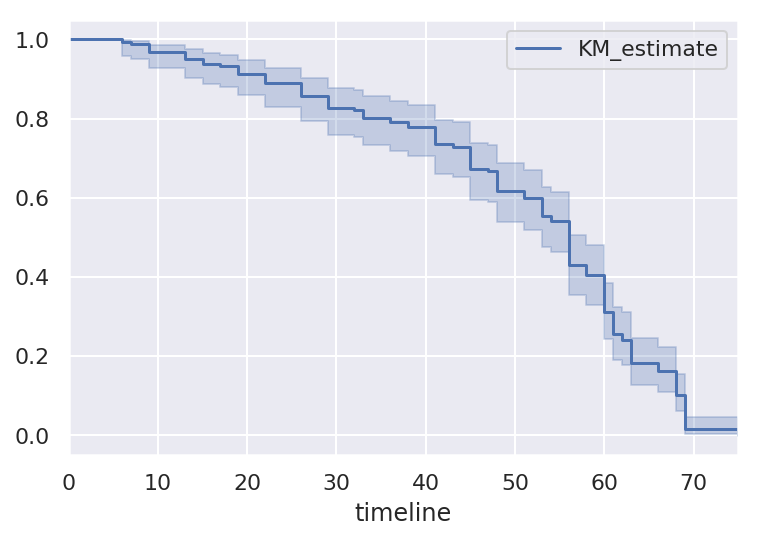

In [35]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)
kmf.plot_survival_function()
# このplotを描くための情報は
# kmf.survival_function_

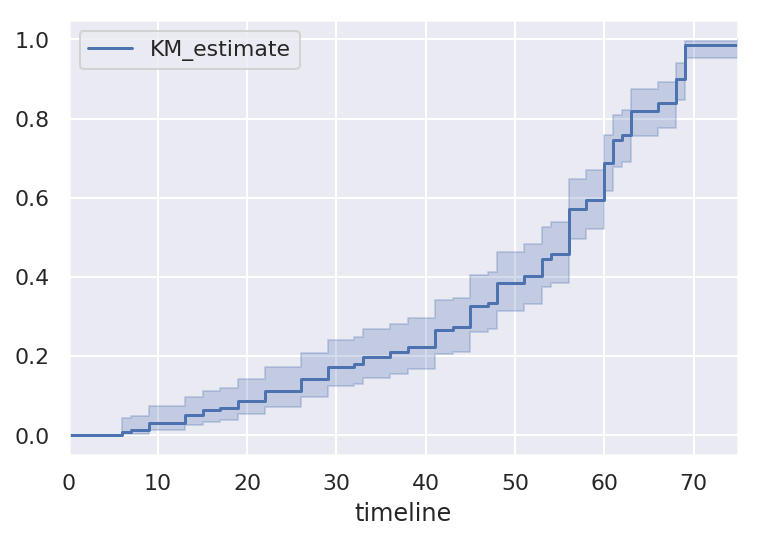

In [36]:
kmf.plot_cumulative_density()
# kmf.cumulative_density_

半分死ぬdurationはmedian_survival_time_に格納されている。ただしconfidence intervalを出すには以下のようにしなければ行けない。

In [37]:
print(kmf.median_survival_time_)
from lifelines.utils import median_survival_times
median_survival_times(kmf.confidence_interval_)

56.0


,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,53.0,58.0


いままではduration(timeline)はデータから自動的に取得されていた。つまりそれは一番冗長でなく情報が乗っている構成になっている。しかしこれを指定することもできる。

In [38]:
kmf.fit(T, E, timeline=range(0, 100, 2))
kmf.survival_function_.head()   # index is now the same as range(0, 100, 2)

,KM_estimate
timeline,
0.0,1.000000
2.0,1.000000
4.0,1.000000
6.0,0.993865
8.0,0.987730


先程はKaplan-Meierという手法を用いた。けど他の手法も使える(とくにパラメトリックモデル)

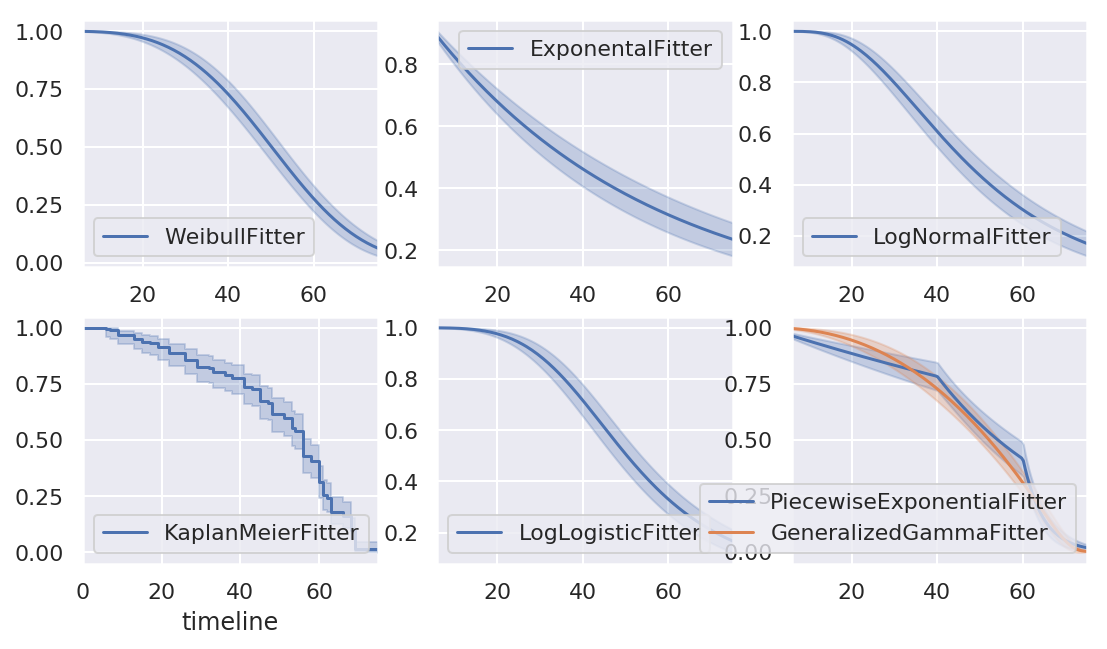

In [39]:
from lifelines import *

fig, axes = plt.subplots(2, 3, figsize=(9, 5))

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentalFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
ggf.plot_survival_function(ax=axes[1][2]) #これで重ねる事ができる

生存分析の比較

さきほどのデータにはcontrol群と投与群(?)の両方が含まれている。それらを比較してみよう

In [40]:
df['group'].value_counts()

control    129
miR-137     34
Name: group, dtype: int64

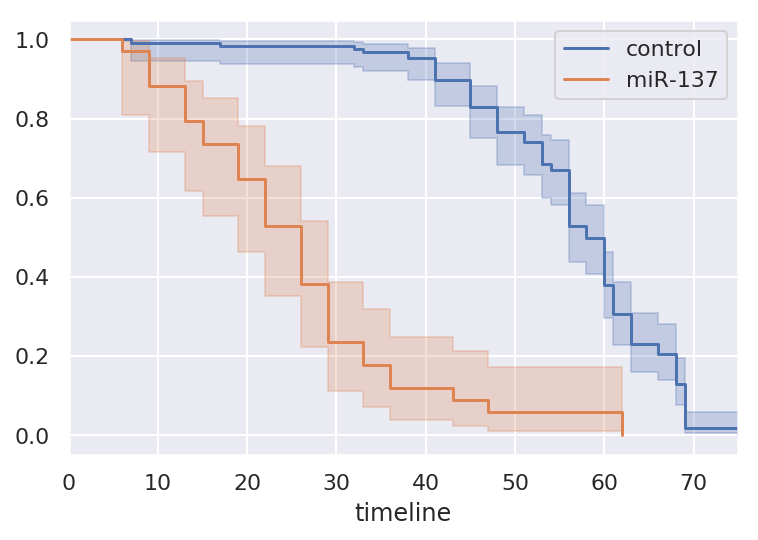

In [41]:
idx= df['group']=='miR-137'

kmf.fit(T[~idx], E[~idx], label='control')
ax = kmf.plot()

kmf.fit(T[idx], E[idx], label='miR-137')
ax = kmf.plot(ax=ax)

データの整形について

よくあるデータの形式として以下のような状況が考えられる
```
*start_time1*, *end_time1*
*start_time2*, *end_time2*
*start_time3*, None
*start_time4*, *end_time4*
```

これは`lifelines.utils.datetimes_to_durations()`を用いることで整形が可能である


```python
from lifelines.utils import datetimes_to_durations
T, E = datetimes_to_durations(start_times, end_times, freq='h')
# start_times is a vector or list of datetime objects or datetime strings
# end_times is a vector or list of (possibly missing) datetime objects or datetime strings
```

各時刻における統計情報的な？

In [49]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,163,163
6.0,1,1,0,0,163
7.0,2,1,1,0,162
9.0,3,3,0,0,160
13.0,3,3,0,0,157


In [51]:
df[df['T']==7.0] #どうやらE==0がcensoredらしい

,T,E,group
88,7.0,1,control
89,7.0,0,control


In [52]:
table.tail()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
63.0,9,9,0,0,36
66.0,3,3,0,0,27
68.0,10,9,1,0,24
69.0,13,12,1,0,14
75.0,1,1,0,0,1
